## NIPS 2017 figure 2b: application of likelihood-free to GLM and comparison to sampling

In [41]:
%matplotlib inline
from __future__ import division
import numpy as np
import scipy.signal as ss
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pypolyagamma import PyPolyaGamma
from math import factorial

import likelihoodfree.io as io
import likelihoodfree.viz as viz
import likelihoodfree.PDF as lfpdf
import os

import svgutils.transform as sg

## Some parameters of the analysis

In [58]:
# to save or not to save plots
save_plot_flag = 1

###############################################################################
# number of parameters inferred
num_param_inf = 10

###############################################################################
# number of repeats
seed_list = np.array([1,2,3])
num_rep = len(seed_list)

###############################################################################
# number of simulations per iteration
sim_step = 5000
num_round = 5
num_sim = np.linspace(sim_step, num_round*sim_step, num_round).astype(int)

###############################################################################
# colors
col_original = (35/255,86/255,167/255)
col_lfree = (0, 174/255,239/255)
col_samp = (244/255, 152/255, 25/255)

## Loading files

In [59]:
# loading filenames, paths and data
iw_loss_ind = 1
preprefix_list = [str(num_param_inf)+'sta_'+str(sim_step)+'_svi',str(num_param_inf)+'sta_'+str(sim_step)+'_iwloss_svi']
prefix = preprefix_list[iw_loss_ind]+'_seed'+str(seed_list[0])
basepath = '../results/glm/'
dir_nets = basepath + 'nets/'
dir_plots = basepath + 'plots/'
sampler_plots = basepath + 'sampler/'

# create folder for plots
if save_plot_flag:
    if not os.path.exists(dir_plots):
        os.makedirs(dir_plots)

###############################################################################
# loading data and posteriors
dists, infos, losses, nets, posteriors, sims = io.load_prefix(dir_nets, prefix)

# data
l_sims = list(sims.items())
obs_stats = l_sims[len(sims)-1][1].obs
y_obs = l_sims[len(sims)-1][1].obs_trace.reshape(-1,1)

# posterior
l_posteriors = list(posteriors.items())
posterior = l_posteriors[len(l_posteriors)-1][1]

###############################################################################
# ground-truth parameters
gt = l_sims[0][1].true_params

###############################################################################
# time
t = l_sims[0][1].t

###############################################################################
# input
I = l_sims[0][1].I_obs
I = I.reshape(1,-1)

## Sampler

In [60]:
# SIMULATION PROTOCOL:
N = 1   # Number of trials
M = num_param_inf-1   # Length of the filter

# build covariate matrix X, such that X * h returns convolution of x with filter h
X = np.zeros(shape=(len(t), M))
for j in range(M):
    X[j:,j] = I[0,0:len(t)-j]

###############################################################################
# prior: Smoothing prior on h; N(0, 1) on b0. Smoothness encouraged by penalyzing 
# 2nd order differences of elements of filter
D = np.diag(np.ones(M)) - np.diag(np.ones(M-1), -1)
F = np.dot(D, D)
# Binv is block diagonal
Binv1 = np.zeros(shape=(M+1,M+1))
Binv1[0,0] = 1    # offset (b0)
Binv1[1:,1:] = np.dot(F.T, F) # filter (h)
prior_dist = lfpdf.Gaussian(m=gt*0., P=Binv1)

BETA_sub_samp = np.load(sampler_plots + 'sampling_'+str(num_param_inf)+'sta.npy')

## Plotting modes and means

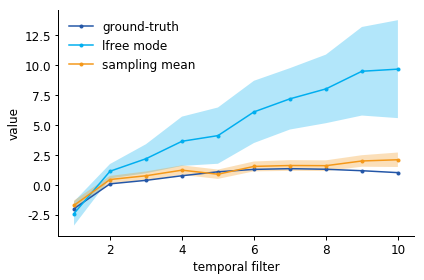

In [61]:
fig = plt.figure()

m_samp = np.mean(BETA_sub_samp,axis=1)
cov_samp = np.cov(BETA_sub_samp)

m, S = posterior.calc_mean_and_cov()

plt.fill_between(np.linspace(1,num_param_inf,num_param_inf), m-np.sqrt(np.diag(S)),
                 m+np.sqrt(np.diag(S)),facecolor=col_lfree,alpha=0.3)
plt.fill_between(np.linspace(1,num_param_inf,num_param_inf), m_samp-np.sqrt(np.diag(cov_samp)),
                 m_samp+np.sqrt(np.diag(cov_samp)),facecolor=col_samp,alpha=0.3)

plt.plot(np.linspace(1,num_param_inf,num_param_inf),gt,'-o', color = col_original,
             label='ground-truth')
plt.plot(np.linspace(1,num_param_inf,num_param_inf),m,'-o',color = col_lfree,
         label='lfree mode')
plt.plot(np.linspace(1,num_param_inf,num_param_inf),m_samp,'-o',color = col_samp,
         label='sampling mean')

ax.set_xticks(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
plt.xlabel('temporal filter')
plt.ylabel('value')
# plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.legend()

plt.tight_layout()

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_summary_samp_lfree_modes' + prefix + '.svg')
plt.show()

## Plotting covariances

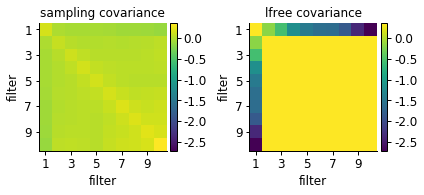

In [62]:
fig = plt.figure()

min_cov = np.min([np.min(cov_samp),np.min(S)])
max_cov = np.min([np.max(cov_samp),np.max(S)])

ax = plt.subplot(1,2,1)
im = plt.imshow(cov_samp, clim=(min_cov, max_cov), interpolation='none')
ax.set_xticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
ax.set_yticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
ax.set_xticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
ax.set_yticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
plt.xlabel('filter')
plt.ylabel('filter')
plt.title('sampling covariance')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = plt.subplot(1,2,2)
im = plt.imshow(S, clim=(min_cov, max_cov), interpolation='none')
ax.set_xticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
ax.set_yticks(np.linspace(0,num_param_inf-2,int(num_param_inf/2)).astype(int))
ax.set_xticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
ax.set_yticklabels(np.linspace(1,num_param_inf-1,int(num_param_inf/2)).astype(int))
plt.xlabel('filter')
plt.ylabel('filter')
plt.title('lfree covariance')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_summary_samp_lfree_covs' + prefix + '.svg')
plt.show()

## Partial view of posterior

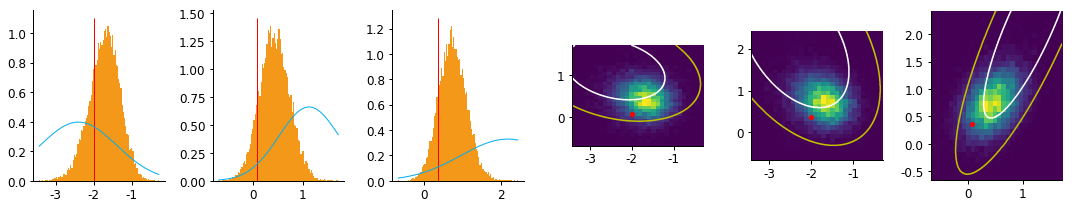

In [64]:
f = plt.subplots(1,6,figsize=(15,3))

levels=(0.68, 0.95)

for ii in range(min(posterior.ndim,3)):
    for j in range(ii,min(posterior.ndim,3)):

        if ii == j:
            ax = plt.subplot(1,6,ii+1)

            samp_plot = BETA_sub_samp[ii,:]
            ax.hist(samp_plot,bins=100,normed = True,color=col_samp)

            lims = np.array([np.min(samp_plot),np.max(samp_plot)])
            xx = np.linspace(lims[0], lims[1], 500)

            pp = posterior.eval(xx, ii=[ii], log=False)
            ax.plot(xx, pp, lw=1, color=col_lfree)
            ax.vlines(gt[ii], 0, ax.get_ylim()[1], lw=1, color='r')

        else:
            ax = plt.subplot(1,6,3+ii+j)

            samp_plot_ii = BETA_sub_samp[ii,:]
            samp_plot_j = BETA_sub_samp[j,:]
            H, xedges, yedges = np.histogram2d(samp_plot_ii, samp_plot_j, bins=30,normed = True)
            ax.imshow(H.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0],
                                                   yedges[-1]],interpolation='none')

            lims = np.array([[np.min(samp_plot_ii),np.max(samp_plot_ii)],[np.min(samp_plot_j),
                              np.max(samp_plot_j)]])
            xx = np.linspace(lims[0, 0], lims[0, 1], 500)
            yy = np.linspace(lims[1 ,0], lims[1, 1], 500)
            X, Y = np.meshgrid(xx, yy)
            xy = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

            pp = posterior.eval(xy, ii=[ii, j], log=False)
            pp = pp.reshape(list(X.shape))
            ax.contour(X, Y, viz.probs2contours(pp, levels), levels, lw=1,colors=('w','y'))
            ax.set_xlim(lims[0])
            ax.set_ylim(lims[1])
            ax.plot(gt[ii], gt[j], 'r.', ms=8)
            
            
plt.tight_layout()

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_summary_samp_lfree_posterior' + prefix + '.svg')
plt.show()

## Analysis of convergence

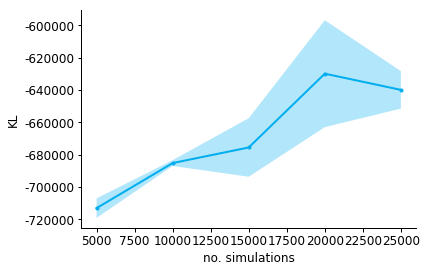

In [65]:
fig = plt.figure()

# GLM log-likelihood for all samples
# binomial coefficient
bin_coeff_t = np.zeros_like(t)
for j in range(len(t)):
    bin_coeff_t[j] = np.log(factorial(N)/(factorial(y_obs[j,0])*factorial(N-y_obs[j,0])))
bin_coeff = np.sum(bin_coeff_t)

# additional two terms of likelihood
y_psi = np.dot(obs_stats,BETA_sub_samp)
psi = np.zeros((len(t),len(BETA_sub_samp[0,:])))
for j in range(len(BETA_sub_samp[0,:])):
    psi[:,j] = BETA_sub_samp[0,j] + ss.lfilter(BETA_sub_samp[1:,j], 1, I.T, axis=0)[:,0]
C = N*np.sum(np.log(1+np.exp(psi)),0)

log_likel_samp = bin_coeff+y_psi-C

############################
# GLM log-posterior (up to the constant log p(data)) for all samples: log(prior)+log(likelihood)
log_prior_samp = prior_dist.eval(BETA_sub_samp.T, log=True)
log_post_samp = np.sum(log_likel_samp+log_prior_samp)


kl_approx = np.zeros((num_rep,len(num_sim)))
for iii in range(num_rep):
    # load all iterations of iii inference
    prefix1 = preprefix_list[iw_loss_ind]+'_seed'+str(seed_list[iii])
    _, _, _, _, posteriors, _ = io.load_prefix(dir_nets, prefix1)
    l_posteriors1 = list(posteriors.items())
    
    for jjj in range(len(num_sim)):
        # compute KL for each jjj iteration of iii inference
        posterior = l_posteriors1[jjj][1]
        pp = posterior.eval(BETA_sub_samp.T, log=False)
        kl_approx[iii,jjj] = log_post_samp - np.sum(np.log(pp))


kl_approx_mn = np.mean(kl_approx,0)
kl_approx_std = np.std(kl_approx,0)

plt.fill_between(num_sim, kl_approx_mn-kl_approx_std,
                 kl_approx_mn+kl_approx_std,facecolor=col_lfree,alpha=0.3)
plt.plot(num_sim,kl_approx_mn,'o-', lw=2, color=col_lfree)
plt.xlabel('no. simulations')
plt.ylabel('KL')

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_summary_samp_lfree_convergence' + preprefix_list[iw_loss_ind] + '.svg')
plt.show()

## Plotting (i) modes, (ii) covariances, (iii) partial view of posterior and (iv) KL between sampling posterior and likelihood-free posterior

In [91]:
#create new SVG figure
fig = sg.SVGFigure("16cm", "6.5cm")

# load matpotlib-generated figures
fig1 = sg.fromfile(dir_plots + 'fig_summary_samp_lfree_modes' + prefix + '.svg')
fig2 = sg.fromfile(dir_plots + 'fig_summary_samp_lfree_covs' + prefix + '.svg')
fig3 = sg.fromfile(dir_plots + 'fig_summary_samp_lfree_convergence' + preprefix_list[iw_loss_ind] + '.svg')
fig4 = sg.fromfile(dir_plots + 'fig_summary_samp_lfree_posterior' + prefix + '.svg')

# get the plot objects
plot1 = fig1.getroot()
plot1.moveto(5, 0, scale=0.4)
plot2 = fig2.getroot()
plot2.moveto(200, 0, scale=0.5)
plot3 = fig3.getroot()
plot3.moveto(420, 0, scale=0.4)
plot4 = fig4.getroot()
plot4.moveto(5, 130, scale=0.5)

# add text labels
txt1 = sg.TextElement(1,20, "C", size=12, weight="bold")
txt2 = sg.TextElement(200,20, "D", size=12, weight="bold")
txt3 = sg.TextElement(420,20, "E", size=12, weight="bold")
txt4 = sg.TextElement(1,130, "F", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot3, plot4])
fig.append([txt1, txt2, txt3, txt4])

# save figure
if save_plot_flag == 1:
    fig.save(dir_plots + 'NIPS2017_fig2b.svg')

## Supplementary figure: analysis of stability for GLM

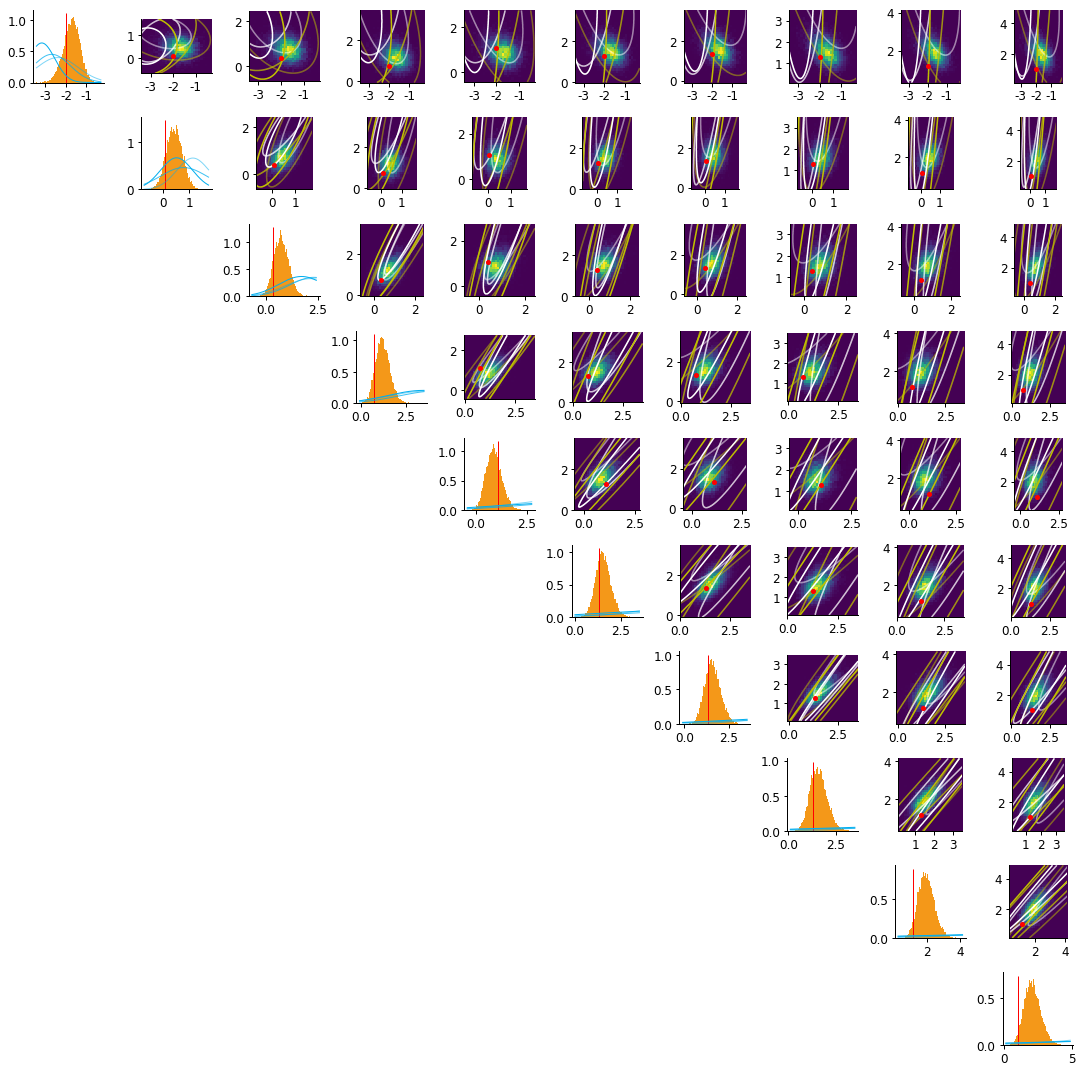

In [67]:
levels=(0.68, 0.95)

alpha_rep = np.linspace(0.5,1,num_rep)
    
f, axs = plt.subplots(1,3,figsize=(np.maximum(5,1.5*posterior.ndim),
                               np.maximum(5,1.5*posterior.ndim)))

posterior_list = []
for iii in range(0,num_rep):

    # load mdn parameters
    prefix1 = preprefix_list[iw_loss_ind]+'_seed'+str(seed_list[iii])
    _, _, _, _, posteriors, _ = io.load_prefix(dir_nets, prefix1)
    l_posteriors1 = list(posteriors.items())
    posterior = l_posteriors1[len(l_posteriors)-1][1]
    posterior_list.append(posterior)

for ii in range(posterior_list[0].ndim):
    for j in range(ii,posterior_list[0].ndim):

        if ii == j:
            ax = plt.subplot2grid((posterior_list[0].ndim, posterior_list[0].ndim), (ii,j))

            samp_plot = BETA_sub_samp[ii,:]
            ax.hist(samp_plot,bins=100,normed = True,color=col_samp)

            lims = np.array([np.min(samp_plot),np.max(samp_plot)])
            xx = np.linspace(lims[0], lims[1], 500)

            for iii in range(num_rep):
                pp = posterior_list[iii].eval(xx, ii=[ii], log=False)
                ax.plot(xx, pp, lw=1, color=col_lfree, alpha=alpha_rep[iii])
            ax.vlines(gt[ii], 0, ax.get_ylim()[1], lw=1, color='r')

        else:
            ax = plt.subplot2grid((posterior_list[0].ndim, posterior_list[0].ndim), (ii,j))

            samp_plot_ii = BETA_sub_samp[ii,:]
            samp_plot_j = BETA_sub_samp[j,:]
            H, xedges, yedges = np.histogram2d(samp_plot_ii, samp_plot_j, bins=30,normed = True)
            ax.imshow(H.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0],
                                                   yedges[-1]],interpolation='none')

            lims = np.array([[np.min(samp_plot_ii),np.max(samp_plot_ii)],[np.min(samp_plot_j),
                              np.max(samp_plot_j)]])
            xx = np.linspace(lims[0, 0], lims[0, 1], 500)
            yy = np.linspace(lims[1 ,0], lims[1, 1], 500)
            X, Y = np.meshgrid(xx, yy)
            xy = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

            for iii in range(num_rep):
                pp = posterior_list[iii].eval(xy, ii=[ii, j], log=False)
                pp = pp.reshape(list(X.shape))
                ax.contour(X, Y, viz.probs2contours(pp, levels), levels, lw=1,
                           colors=('w','y'),alpha=alpha_rep[iii])
            ax.set_xlim(lims[0])
            ax.set_ylim(lims[1])
            ax.plot(gt[ii], gt[j], 'r.', ms=8)

plt.tight_layout()

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'NIPS2017_suppfig_GLM.svg')
plt.show()